# **Unsupervised Learning: diffusion models**


Diffusion models are nothing new. They concept was brought forward long ago, but the most popular implementation using Deep Learning was done by Ho et al. in "Denoising Diffusion Probabilistic Models" (https://arxiv.org/abs/2006.11239). Diffusion models take an image and add Gaussian Noise to it over a series of T time-steps in what's called the "forward process". In the "backward process", a noise sample is drawn, and denoised over these T steps to retrieve this image. In Ho et al., it is assumed that a Markov process takes place in both directions (where each latent depends only on the previous one).

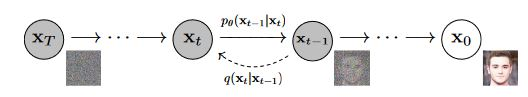


This notebook will use the architecture blocks available under MONAI Generative Models, namely:

*   autoencoderkl, which will allow us to easily implement a Spatial VAE, necessary for the latent diffusion model implementation
*   diffusion_model_unet, which contains the diffusion model architecture itself
*   schedulers > ddpm, which implements the schedulers used to train and iterate through the noising / denoising process
*   inferers, which wraps the diffusion model and the scheduler to ease the forward and inference calls.

In this notebook, we will explain how these different blocks work and how to use them. However, if you want to check each individual script to see the source code for each of these building blocks, feel free to do so at: https://github.com/Project-MONAI/GenerativeModels.git




### Use-all functions
The following functions will be used across the notebook.

In [1]:
! pip install monai
! pip install monai-generative


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 3.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [15]:
# IMPORTS
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import monai
import generative
from generative.networks.nets import DiffusionModelUNet, AutoencoderKL
from generative.networks.schedulers import DDPMScheduler
from generative.inferers import DiffusionInferer, LatentDiffusionInferer
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

In [327]:
# Plot

def process_dm_output(images: torch.Tensor, intermediates: torch.Tensor = None, random_batch: bool = False, with_anomaly: bool = False):
  out = []
  if random_batch:
    b = np.random.randint(images.shape[0])
    if intermediates is not None:
      for int_ in intermediates[:-1]:
        out.append(int_[b, 0].detach().cpu().numpy())
    out.append(images[b, 0].detach().cpu().numpy())
    if with_anomaly:
        return np.concatenate(out, 1), b
    else:
        return np.concatenate(out, 1)
  else:
    for b in range(images.shape[0]):
        batch_el = []
        if intermediates is not None:
            for int_ in intermediates[:-1]:
                batch_el.append(int_[b, 0].detach().cpu().numpy())
        batch_el.append(images[b, 0].detach().cpu().numpy())
        out.append(np.concatenate(batch_el, 1))
    if with_anomaly:
        return np.concatenate(out, 0), None
    else:
        return np.concatenate(out, 0)

def log_ae_result(image: torch.Tensor, ground_truth: torch.Tensor, random_batch: bool = False):

    out = []
    if random_batch:
        b = np.random.randint(image.shape[0]);
        out.append(np.concatenate([image[b, 0, ...].detach().cpu().numpy(),
                    ground_truth[b,0,...].detach().cpu().numpy()], 1))
    else:
        for b in range(image.shape[0]):
            out.append(np.concatenate([image[b, 0, ...].detach().cpu().numpy(),
                        ground_truth[b,0,...].detach().cpu().numpy()], 1))
    return np.concatenate(out, 0)
    

### 0. Data

We are going to use MedNISTDataset (https://medmnist.com/). In particular, chest X-Ray images. MONAI Apps allows you to download, extract, and handle MedNISTDataset easily.

In [17]:
# Data arguments
batch_size = 8
num_workers = 4

In [18]:
from monai.apps import MedNISTDataset
import tempfile
directory = None # You can set this directory if there is a place where you want to save this.
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

# Training, validation and test splits:
mednist_data_tr = MedNISTDataset(root_dir, section = "training", transform=(), download=True, progress = False)
mednist_data_va = MedNISTDataset(root_dir, section = "validation", transform=(), download=True, progress = False)
mednist_data_te = MedNISTDataset(root_dir, section = "test", transform=(), download=True, progress = False)


/tmp/tmphzybhqo_
2024-02-08 08:03:37,397 - INFO - Downloaded: /tmp/tmphzybhqo_/MedNIST.tar.gz
2024-02-08 08:03:37,466 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-02-08 08:03:37,467 - INFO - Writing into directory: /tmp/tmphzybhqo_.
2024-02-08 08:03:56,896 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-02-08 08:03:56,896 - INFO - File exists: /tmp/tmphzybhqo_/MedNIST.tar.gz, skipped downloading.
2024-02-08 08:03:56,897 - INFO - Non-empty folder exists in /tmp/tmphzybhqo_/MedNIST, skipped extracting.
2024-02-08 08:03:58,868 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-02-08 08:03:58,869 - INFO - File exists: /tmp/tmphzybhqo_/MedNIST.tar.gz, skipped downloading.
2024-02-08 08:03:58,870 - INFO - Non-empty folder exists in /tmp/tmphzybhqo_/MedNIST, skipped extracting.


In [19]:
# Lists of data files

list_data_training =  [{"image": item["image"]} for item in mednist_data_tr.data if item["class_name"] == "CXR"]
list_data_validation =  [{"image": item["image"]} for item in mednist_data_va.data if item["class_name"] == "CXR"]
list_data_test =  [{"image": item["image"]} for item in mednist_data_te.data if item["class_name"] == "CXR"]

transforms = [monai.transforms.LoadImaged(keys=['image']),
              monai.transforms.EnsureChannelFirstd(keys=['image']),
              monai.transforms.ScaleIntensityRanged(keys=['image'], a_max = 255, a_min = 0, b_max = 1.0, b_min = 0.0, clip = True),
              monai.transforms.Rotated(keys=['image'], angle = np.pi/2),
              monai.transforms.RandAffined(keys=['image'],
                                           rotate_range=[-0.1, 0.1],
                                           scale_range=[-0.05, 0.05],
                                           )
              ]

training_dataset = monai.data.Dataset(list_data_training, monai.transforms.Compose(transforms))
validation_dataset = monai.data.Dataset(list_data_validation, monai.transforms.Compose(transforms[:-1]))
test_dataset = monai.data.Dataset(list_data_test, monai.transforms.Compose(transforms[:-1]))

training_loader = monai.data.DataLoader(training_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
validation_loader = monai.data.DataLoader(validation_dataset, batch_size = batch_size, num_workers = num_workers)
test_loader = monai.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers)

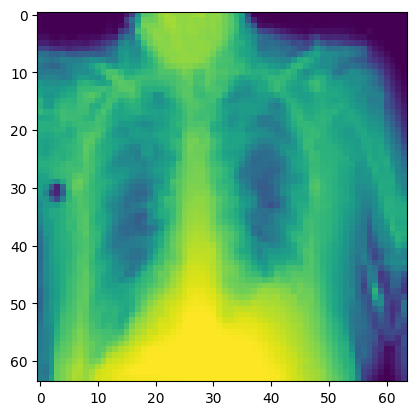

Max: 0.000, min: 1.000


In [20]:

item = next(iter(training_loader))
plt.imshow(item['image'][0,0,...]); plt.show()
print("Max: %.3f, min: %.3f" %(item['image'].min(), item['image'].max()))

### 1. Training a diffusion model

### Architecture
Diffusion models are implemented using a single neural network: this means that the same network predicts the next stage for the whole Markov Chain. To make this work, the network needs to be aware of the stage it is in. Hence, diffusion models have to take in, in addition to the input image, a time step, which is any number between 1 and T (T = total number of diffusion time steps).

The network architecture is a res-U-Net (a U-Net with residual blocks). Each residual block takes in the previous activations, as well as the time-step embedding. The time-step (i.e. 542, 19, 802 etc.) is fed to a block that creates a 1D vector, or embedding, which is fed to all residual blocks across the network.

In addition, diffusion models are typically implemented using attention layers, which make it possible to:


*   Make the network focus on important details about its activations, that will lead to a better output (self-attention layers)
*   Allow for the network to take in extra conditioning (i.e.: in Chest X-Ray, it could be a vector coding for a specific pathology)

In this notebook, we will not use conditioning (therefore, we will not have cross-attention layers), but we will use self-attention. These layers go after each residual block.

#### Objective

The objective of a diffusion model ends up being similar to that of a variational auto-encoder. Its derivation can be checked in Bishop's "Deep Learning: Foundation and Concepts" (2024) (https://www.bishopbook.com/). Essentially, optimising a diffusion model, assuming that the variance between time steps is small, is analogous to make it predict the noise that is added between time steps t and (t-1), given a noisy sample (image that has gone through t noising steps).

#### Scheduler

Because we make the network predict the added noise, obtaining the noisy image at t-1 from the predicted noise between t and t-1 requires certain operations that involve variables such as the variance between time steps, and the cumulative product between variances up to step t. This  - as well as the noising of the image - is handled by an object called scheduler that will work along with our diffusion model. This object does not have any optimisable parameters, it just helps making sense of what goes in and out of the model.

#### Forward pass

During a forward call, the loss for a single time-step is calculated. A time-step is randomly selected (here, T=1000, and we select a random integer between 1 and 1000). The process is as follows:



1.   A random time step t is selected.
2.   The input image is noised for t steps (forward process).
3.   This noised image is fed through the network, along with t. The network predicts the noise that has been added between (t-1) and t, which should be Gaussian N(0,1).
4.   We calculate an L1 or L2 loss between the predicted noise and a N(0,1) noise sample and backpropagate this loss.


#### Inference

During inference, we go from a noise sample to an image: this requires to loop across the whole Markov chain, and call the diffusion model T times, using the scheduler to obtain the denoised image at each step. Other schedulers can be used to speed this up, at the expense of performance, using tricks that allow to sample fewer time steps. Here, we will stick to the original scheduler for inference as well, but these other faster schedulers can be easily used at inference time and are also implemented in the repository (DDIM, PNDM).







In [28]:
# Configuration
# Diffusion model configuration
spatial_dims = 2 # We are using 2D
in_channels = 1 # One channel only
num_channels = (64, 128, 256) # Number of channels at every level of the U-Net
attention_levels = (False, True, True) # At which level of the U-Net you want attention levels: attention blocks have a lot of parameters,
#and they can slow optimisation time, and also take a lot of GPU space, so you can't always have a lot of them.
num_res_blocks = 1 # Number of residual blocks per U-Net level
num_head_channels = 8 # This is the number of different attention heads in the attention blocks (the more, the more things in parallel your attention blocks will be looking at in the input)
with_conditioning = False

# Scheduler configuration
# With number_time_steps, beta_start and beta_end, our scheduler will automatically calculate the variance of the noise that gets added (and accumulates) across the forward process.
number_time_steps = 1000
schedule = "scaled_linear_beta" # The schedule is the way noise evolves during the forward process: it can be a cosine function, linear etc. linear is the most common.
prediction_type = "epsilon" # We are saying that our network is predicting the added noise between steps. This is not always true: other approaches can be used (such as predicting the denoised image
#directly, or a mix between the two). To keep things simple, we stick with predicting the noise, which is what 'epsilon' is doing.
beta_start = 0.0015 # Variance at the beginning of the process
beta_end = 0.0195 # Varance at the end of the process


In [29]:
diffusion_model = DiffusionModelUNet(
    spatial_dims = spatial_dims,
    in_channels = in_channels,
    out_channels = in_channels,
    num_channels = num_channels,
    attention_levels = attention_levels,
    num_res_blocks = num_res_blocks,
    num_head_channels = num_head_channels,
    with_conditioning = with_conditioning
)

scheduler = DDPMScheduler(
    num_train_timesteps = number_time_steps,
    schedule = schedule,
    prediction_type = prediction_type,
    beta_start = beta_start,
    beta_end = beta_end,
)

In [30]:
# If you want to have a look at the layers.
print(diffusion_model)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (op):

Also to ease our training code, another class can be summoned to control the forward call, as well as the sampling (looping through all time steps, and calling the scheduler at every time step so that it removes the predicted noise from the image). This object is called the inferer.

In [31]:
inferer = DiffusionInferer(scheduler = scheduler)

Now we are ready to launch the training! Let's define some basic training variables first.
**Note**: _We will use automatic mixed precision (AMP) to avoid clotting the GPU!_

In [36]:
n_epochs = 15
lr = 0.00005
validate_every = 1
sample_every = 1
val_losses = []
train_losses = []
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=lr)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.mse_loss
scaler = GradScaler() # AMP setting
print("Device set to: %s" %device)
diffusion_model.to(device);

Device set to: cuda


Epoch 0: 100%|████████████████████████████████| 998/998 [01:20<00:00, 12.47it/s, train_loss=0.00915]

Validation


Validation loss: 0.011


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.86it/s]


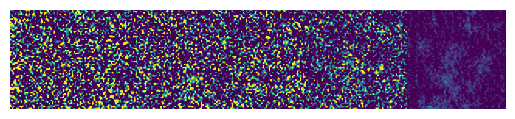

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 1: 100%|█████████████████████████████████| 998/998 [01:20<00:00, 12.43it/s, train_loss=0.0164]

Validation


Validation loss: 0.010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.56it/s]


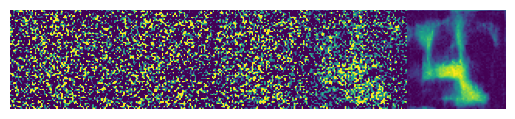

Epoch 2: 100%|████████████████████████████████| 998/998 [01:20<00:00, 12.37it/s, train_loss=0.00851]

Validation


Validation loss: 0.009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.49it/s]


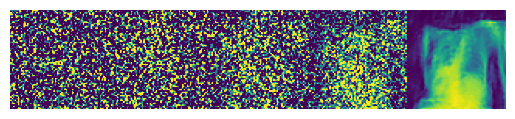

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 3: 100%|█████████████████████████████████| 998/998 [01:21<00:00, 12.21it/s, train_loss=0.0158]

Validation


Validation loss: 0.010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.99it/s]


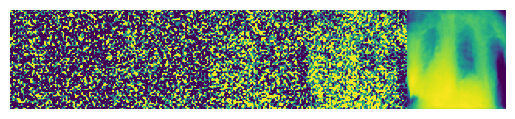

Epoch 4: 100%|███████████████████████████████████| 998/998 [01:21<00:00, 12.23it/s, train_loss=0.01]

Validation


Validation loss: 0.010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.58it/s]


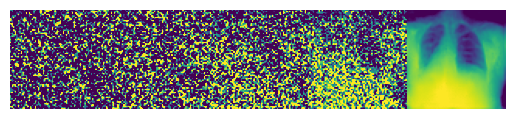

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 5: 100%|█████████████████████████████████| 998/998 [01:19<00:00, 12.55it/s, train_loss=0.0171]

Validation


Validation loss: 0.010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.19it/s]


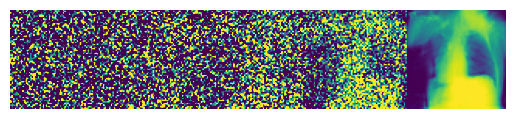

Epoch 6: 100%|████████████████████████████████| 998/998 [01:18<00:00, 12.69it/s, train_loss=0.00194]

Validation


Validation loss: 0.009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.22it/s]


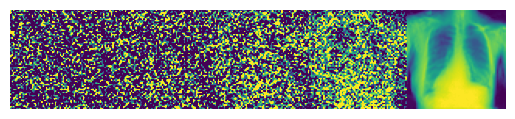

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 7: 100%|████████████████████████████████| 998/998 [01:18<00:00, 12.71it/s, train_loss=0.00847]

Validation


Validation loss: 0.010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.21it/s]


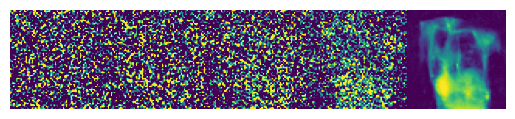

Epoch 8: 100%|████████████████████████████████| 998/998 [01:18<00:00, 12.71it/s, train_loss=0.00665]

Validation


Validation loss: 0.009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.84it/s]


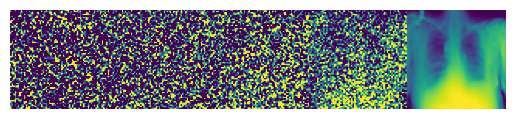

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 9: 100%|█████████████████████████████████| 998/998 [01:18<00:00, 12.67it/s, train_loss=0.0315]

Validation


Validation loss: 0.009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.17it/s]


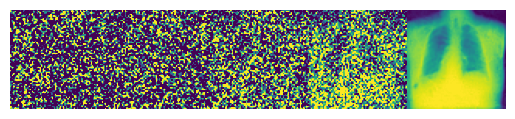

Epoch 10: 100%|████████████████████████████████| 998/998 [01:18<00:00, 12.66it/s, train_loss=0.0129]

Validation


Validation loss: 0.009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.21it/s]


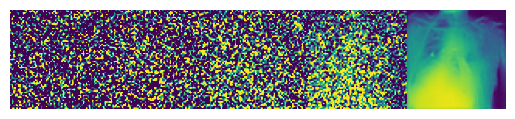

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 11: 100%|███████████████████████████████| 998/998 [01:21<00:00, 12.22it/s, train_loss=0.00608]

Validation


Validation loss: 0.010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.84it/s]


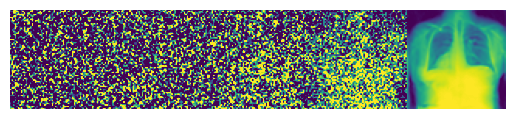

Epoch 12: 100%|███████████████████████████████| 998/998 [01:20<00:00, 12.47it/s, train_loss=0.00614]

Validation


Validation loss: 0.010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.18it/s]


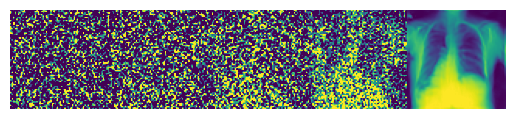

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 13: 100%|████████████████████████████████| 998/998 [01:19<00:00, 12.50it/s, train_loss=0.0077]

Validation


Validation loss: 0.009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.81it/s]


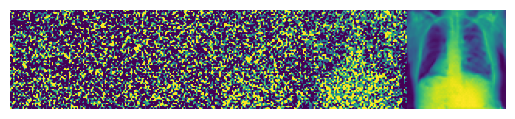

Epoch 14: 100%|███████████████████████████████| 998/998 [01:20<00:00, 12.38it/s, train_loss=0.00208]

Validation


Validation loss: 0.010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.64it/s]


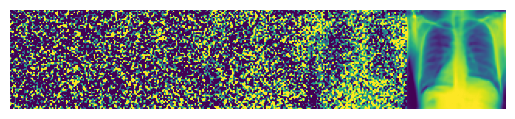

In [37]:
for e in range(n_epochs):
  progress_bar = tqdm(enumerate(training_loader), total = len(training_loader), ncols = 100)
  val_bar = tqdm(enumerate(validation_loader), total = len(validation_loader), ncols = 100)
  progress_bar.set_description("Epoch %d" %e)
  epoch_loss = 0.0
  diffusion_model.train() 
  for ind, batch in progress_bar:
    image = batch['image'].to(device)
    with autocast(enabled = True): # AMP setting
        target = torch.randn(image.shape).to(device)
        t = torch.randint(0, scheduler.num_train_timesteps, (image.shape[0],), device=device).long()
        optimizer.zero_grad()
        noise_pred = inferer(inputs = image, diffusion_model = diffusion_model, noise = target, timesteps = t)
        loss = loss_fn(noise_pred, target)
        scaler.scale(loss).backward() # AMP setting
        scaler.step(optimizer) # AMP setting
        scaler.update() # AMP setting
    epoch_loss += loss.item()
    progress_bar.set_postfix({'train_loss': loss.item()})
  train_losses.append(epoch_loss / len(training_loader))
  if e%validate_every == 0:
      print("Validation")
      diffusion_model.eval()
      val_loss = 0.0
      for batch in validation_loader:
        image = batch['image'].to(device)
        target = torch.randn(image.shape).to(device)
        t = torch.randint(0, scheduler.num_train_timesteps, (image.shape[0],), device=device).long()
        noise_pred = inferer(inputs = image, diffusion_model = diffusion_model, noise = target, timesteps = t)
        loss = loss_fn(noise_pred, target)
        val_loss += loss.item()
      val_losses.append(val_loss / len(validation_loader))
      print("Validation loss: %.3f" %val_losses[-1])

  if e%sample_every == 0:
    noise = torch.randn(image.shape).to(device)
    samples, ints = inferer.sample(input_noise=noise,
                                    diffusion_model=diffusion_model,
                                    scheduler=scheduler,
                                    save_intermediates=True,
                                    intermediate_steps=200)
    # We plot these
    to_plot = process_dm_output(samples, ints, random_batch = True)
    plt.imshow(to_plot, vmin=0, vmax=1,); plt.axis('off')
    plt.show()




Bit of cleaning, just in case...

In [ ]:
diffusion_model = diffusion_model.detach().cpu()

### 2. Training a latent diffusion model (LDM)


Diffusion models are great when you are dealing with small data. In Computer Vision, images tend to be 2D, and many times, they do not even have high resolution. However, in Medical Imaging, we deal with HR data, and in many cases, 3D data. Training a diffusion model with 3D data and a considerable resolution (i.e. > 64^3) is almost intractable. To make it possible to use diffusion models in this context, we can **downsample** the inputs to a **latent space**, and then apply the diffusion model to this **latent space representation**. This downsamples is done via an autoencoder-like architecture: either a spatial VAE or a vector-quantised autoencoder (VQ-VAE), which both yield a **spatial latent space representation** of the input. The diffusion model learns then to map a sample of **random noise** to a latent space sample that can be then passed through the decoder. This pack of an autoencoder + diffusion model is called a **latent diffusion model**. Other than manage higher resolutions, when done properly, a latent space representation can also yield more meaningful outputs.


#### 2.1 Autoencoder

No different from the autoencoders that were covered in the first Generative Models lecture, we will create a spatial autoencoder. The autoencoder in MONAI Generative also allows you to put attention layers within the autoencoder, in a similar fashion as diffusion models.


In [129]:
vae = AutoencoderKL(
    spatial_dims = 2,
    in_channels = 1,
    out_channels = 1,
    num_res_blocks = [2, 2, 2],
    num_channels = [16, 32,64],
    attention_levels = [False, False, False],
    latent_channels = 8,
    norm_num_groups = 16
)


To avoid extra blurring (this is often the case for VAEs) we will add a perceptual loss, which brings back some sharpness. Perceptual loss compares the intermediate features of a pre-trained network (such as Inceptionv3) between input image and reconstructed image. This high level features counteract the loss of texture caused by the objective of the VAE.

In [130]:
n_epochs = 10
lr = 0.0001
w_recon = 1.0
w_perc = 0.5
w_kl = 0.00001
scaler_vae = GradScaler()
recons_loss = torch.nn.functional.l1_loss
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=lr)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device %s" %device)
vae=vae.to(device);
from generative.losses import PerceptualLoss
perceptual_loss = PerceptualLoss(spatial_dims = 2, network_type = "radimagenet_resnet50").to(device)

Device cuda


  0%|                                                                                           | 0/131 [42:55<?, ?it/s]
Epoch 0: 100%|█| 998/998 [01:11<00:00, 13.93it/s, train_loss=0.0795, kl_loss=1.37e+3, recons_loss=0.0364, perc_loss=0.05

Validation


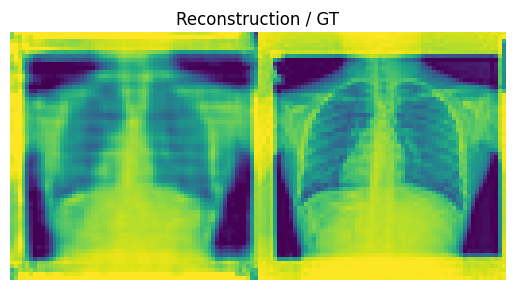

Validation loss: 0.037


  0%|                                                                                           | 0/998 [00:00<?, ?it/s]


  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 1: 100%|█| 998/998 [01:11<00:00, 13.89it/s, train_loss=0.0753, kl_loss=1.35e+3, recons_loss=0.0353, perc_loss=0.05

Validation


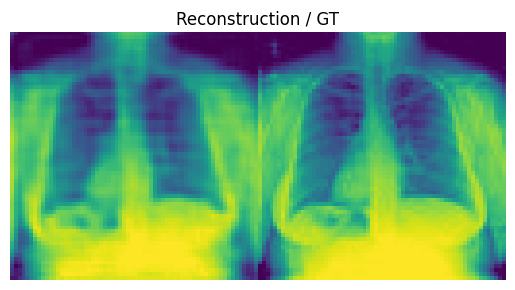

Validation loss: 0.035


  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 2: 100%|█| 998/998 [01:11<00:00, 13.95it/s, train_loss=0.0746, kl_loss=1.35e+3, recons_loss=0.0347, perc_loss=0.05

Validation


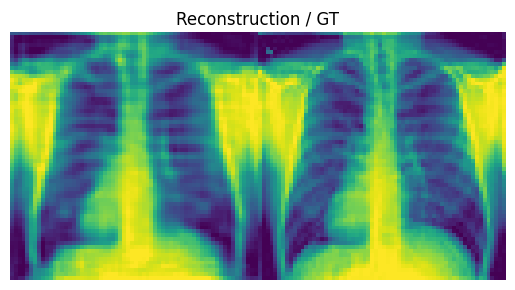

Validation loss: 0.034


  0%|                                                                                           | 0/998 [00:00<?, ?it/s]


  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 3: 100%|█| 998/998 [01:11<00:00, 14.00it/s, train_loss=0.071, kl_loss=1.33e+3, recons_loss=0.0337, perc_loss=0.048

Validation


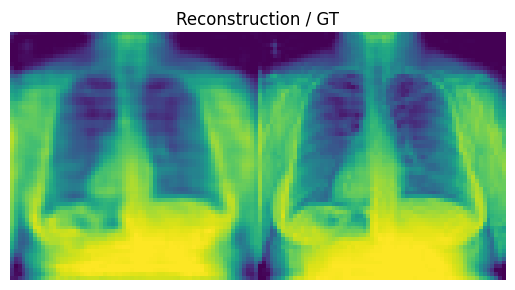

Validation loss: 0.033


  0%|                                                                                           | 0/131 [01:13<?, ?it/s]
Epoch 4: 100%|█| 998/998 [01:11<00:00, 13.94it/s, train_loss=0.0708, kl_loss=1.32e+3, recons_loss=0.0334, perc_loss=0.04

Validation


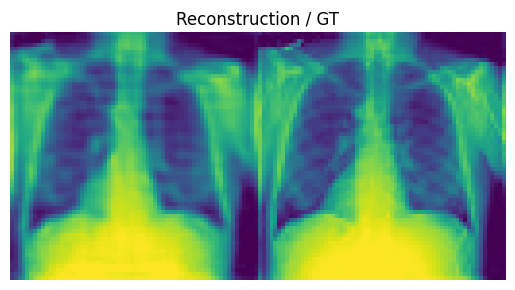

Validation loss: 0.033


  0%|                                                                                           | 0/998 [00:00<?, ?it/s]


  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 5: 100%|█| 998/998 [01:12<00:00, 13.73it/s, train_loss=0.0681, kl_loss=1.32e+3, recons_loss=0.0324, perc_loss=0.04

Validation


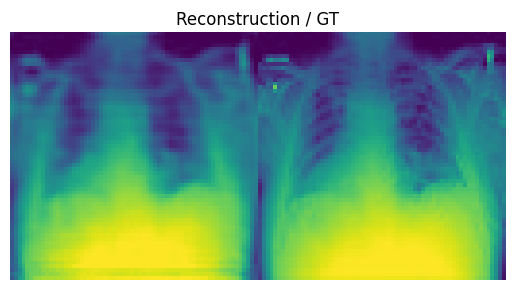

Validation loss: 0.034


  0%|                                                                                           | 0/131 [01:15<?, ?it/s]
Epoch 6: 100%|█| 998/998 [01:11<00:00, 13.88it/s, train_loss=0.066, kl_loss=1.32e+3, recons_loss=0.0318, perc_loss=0.042

Validation


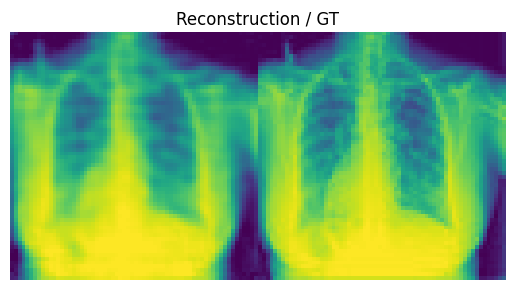

Validation loss: 0.032


  0%|                                                                                           | 0/998 [00:00<?, ?it/s]


  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 7: 100%|█| 998/998 [01:12<00:00, 13.73it/s, train_loss=0.0641, kl_loss=1.32e+3, recons_loss=0.0311, perc_loss=0.03

Validation


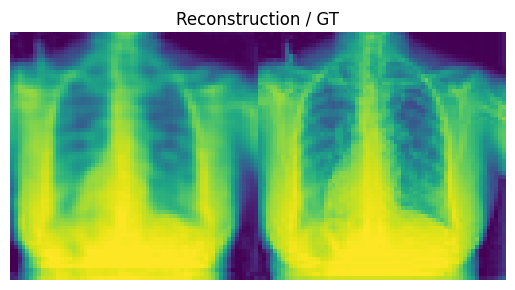

Validation loss: 0.032


  0%|                                                                                           | 0/131 [01:15<?, ?it/s]
Epoch 8: 100%|█| 998/998 [01:11<00:00, 13.93it/s, train_loss=0.0633, kl_loss=1.33e+3, recons_loss=0.0306, perc_loss=0.03

Validation


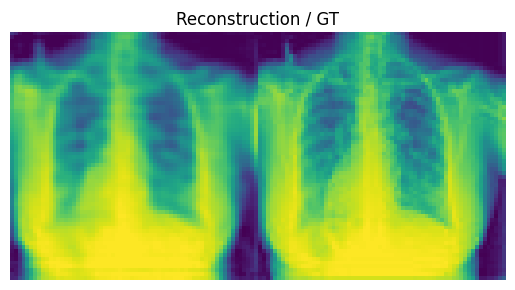

Validation loss: 0.031


  0%|                                                                                           | 0/998 [00:00<?, ?it/s]


  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 9: 100%|█| 998/998 [01:11<00:00, 14.00it/s, train_loss=0.0617, kl_loss=1.34e+3, recons_loss=0.03, perc_loss=0.0365

Validation


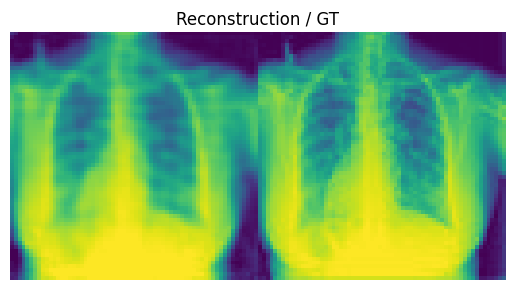

Validation loss: 0.032


In [138]:
val_epoch_loss = 0.0
perceptual_losses = []
recons_losses = []
epoch_losses = []
val_epoch_losses = []
kl_losses = []
for e in range(n_epochs):
  progress_bar = tqdm(enumerate(training_loader), total = len(training_loader), ncols = 120)
  val_bar = tqdm(enumerate(validation_loader), total = len(validation_loader), ncols = 120)
  progress_bar.set_description("Epoch %d" %e)
  epoch_loss = 0.0
  kl_epoch_loss = 0.0
  p_epoch_loss = 0.0
  recons_epoch_loss = 0.0
  vae.train() 
  for ind, batch in progress_bar:
    image = batch['image'].float().to(device)
    with autocast(enabled = True):
        reconstruction, z_mu, z_sigma = vae(image)
        optimizer_vae.zero_grad()
        recons_it_loss = recons_loss(reconstruction, image)
        perc_it_loss = perceptual_loss(reconstruction.float(), image.float())
        kl_it_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2])
        kl_it_loss = torch.sum(kl_it_loss) / kl_it_loss.shape[0]
        loss = w_recon * recons_it_loss + w_perc * perc_it_loss + w_kl * kl_it_loss
    scaler_vae.scale(loss).backward()
    scaler_vae.step(optimizer_vae)
    scaler_vae.update()
    epoch_loss += loss.item()
    kl_epoch_loss += kl_it_loss.item()
    p_epoch_loss += perc_it_loss.item()
    recons_epoch_loss +=recons_it_loss.item()
    del reconstruction, z_mu, z_sigma, loss, perc_it_loss, recons_it_loss, kl_it_loss
    progress_bar.set_postfix({'train_loss': epoch_loss / (ind+1), 
                              'kl_loss': kl_epoch_loss /(ind+1),
                              'recons_loss': recons_epoch_loss / (ind+1),
                              'perc_loss': p_epoch_loss / (ind+1)})
  recons_losses.append(recons_epoch_loss / len(training_loader)) 
  kl_losses.append(kl_epoch_loss / len(training_loader)) 
  perceptual_losses.append(p_epoch_loss / len(training_loader))
  epoch_losses.append(epoch_loss / len(training_loader))
  train_losses.append(epoch_loss / len(training_loader))
    
  if e%validate_every == 0:
      print("Validation")
      vae.eval()
      vae_epoch_loss = 0.0
      for ind, batch in enumerate(validation_loader):
        image = batch['image'].to(device)
        reconstruction, _, _ = vae(image)
        recons_it_loss = recons_loss(reconstruction, image)
        val_epoch_loss += recons_it_loss.item()
        if ind==0:
            to_plot = log_ae_result(reconstruction, image, random_batch = True)
            plt.imshow(to_plot, vmin = 0.0, vmax = 1.0); plt.axis('off'); plt.title("Reconstruction / GT");plt.show();
        del recons_it_loss, reconstruction, image 
      val_epoch_loss = val_epoch_loss / len(validation_loader)
      print("Validation loss: %.3f" %val_epoch_loss)
  val_epoch_losses.append(val_epoch_loss)

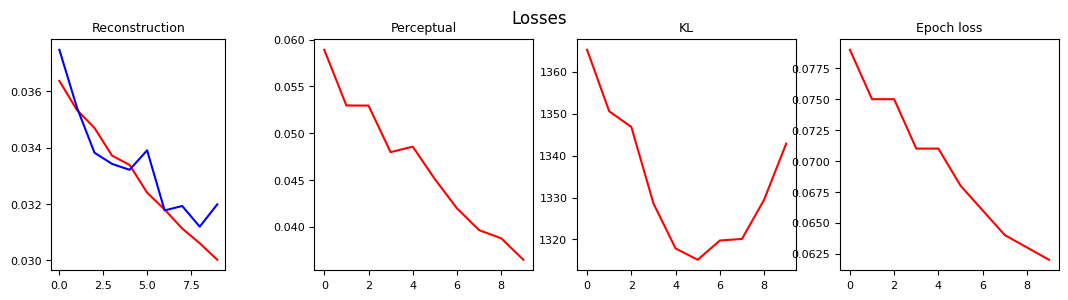

In [151]:
# Plot the losses
f = plt.figure(figsize=(13,3));
epochs = list(range(n_epochs));
plt.subplot(1,5,1); plt.plot(epochs, recons_losses, 'r'); plt.plot(epochs, val_epoch_losses, 'b'); plt.title("Reconstruction", fontsize=9);
plt.legend(['training', 'validation']); 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.subplot(1,4,2); plt.plot(epochs, perceptual_losses, 'r'); plt.title("Perceptual", fontsize=9);
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.subplot(1,4,3); plt.plot(epochs, kl_losses, 'r'); plt.title("KL", fontsize=9);
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.subplot(1,4,4); plt.plot(epochs, [np.round(i,3) for i in epoch_losses], 'r'); plt.title("Epoch loss", fontsize=9);
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.suptitle("Losses"); 

As we can see, 10 epochs is not enough to have convergence. But we will try to go on with this model. Feel free to train for longer. Note that the KL divergence goes up at the end; this is nothing to worry about. In practice, you try to find a balance for your latent space, trying to make it somewhat Gaussian, but not excessively, as that would compromise the disentanglement that might exist in the original distribution.

#### 2.2 Diffusion model

Now we are working on the latent space of the autoencoder. Hence, we need to forward images through our autoencoder before plucking them into the diffusion model. When we do inference, we need to decode the diffusion model outputs. For this, we will switch from DiffusionInferer to LatentDiffusionInferer. This inferer takes care of passing things to the autoencoder, first, and decoding things at inference.
Two things change in the latent inferer code that you can customize:


*   **scale factor**: the latent space intensities are not necessarily within a Gaussian range. This can be an issue, because when you set your variance schedule, it will work well if, at the end of your chain, you end up with a fairly Gaussian distribution. If your range is too big, you might end up with something that is very non-Gaussian at the end, and then your diffusion model will not work. The scale factor is a multiplier you can set before and after you diffuse things, to scale the intensities of the latent space. This is assigned by the user, but typically, a good scale factor would be 1/torch.std(z), where z is a latent space tensor.
*   **crops and pads**: the idea is that your latent space is smaller than your input. But keep in mind that, within the diffusion model, downsamplings and upsamplings take place. In some modalities, such as brain imaging, one dimension might be smaller (i.e. because you try to crop the images to get the brain only, the width tends to be smaller than heigh). If your input dimension is e.g. 80, and your autoencoder has 3 downsamplings, you will end up with dimension 10 in the latent space. Now, if your DM has also 3 downsamplings, you will have 5, and then you will run into an issue, because you will have an odd dimension that cannot be divided by 2 (the network will do it, but then you will run into issues when upsampling or concatenating the skip connections). The inferer allows you to pad and crop the latent space after and before the autoencoder to ensure that what is passed to the diffusion model can be divided by 2**(n_downsamplings) across all dimensions.





In [154]:
# Which scale factor will be good? We calculate the average of 1/torch.std(z) for our test set.
vae.to(device)
potential_scale_factor = 0.0
for batch in test_loader:
  im = batch['image'].to(device)
  z = vae.encode_stage_2_inputs(im)
  potential_scale_factor += (1/torch.std(z)).item()
potential_scale_factor /= len(test_loader)
print(potential_scale_factor)

0.9791393028803108


In [169]:
# Configuration
# Diffusion model configuration
spatial_dims = 2 # We are using 2D
in_channels = 8 # Now we have the number of latent channels!
num_channels = (64, 128, 256) # Number of channels at every level of the U-Net
attention_levels = (False, True, True) # At which level of the U-Net you want attention levels: attention blocks have a lot of parameters,
#and they can slow optimisation time, and also take a lot of GPU space, so you can't always have a lot of them.
num_res_blocks = 1 # Number of residual blocks per U-Net level
num_head_channels = 8 # This is the number of different attention heads in the attention blocks (the more, the more things in parallel your attention blocks will be looking at in the input)
with_conditioning = False

# Scheduler configuration
# With number_time_steps, beta_start and beta_end, our scheduler will automatically calculate the variance of the noise that gets added (and accumulates) across the forward process.
number_time_steps = 1000
schedule = "scaled_linear_beta" # The schedule is the way noise evolves during the forward process: it can be a cosine function, linear etc. linear is the most common.
prediction_type = "epsilon" # We are saying that our network is predicting the added noise between steps. This is not always true: other approaches can be used (such as predicting the denoised image
#directly, or a mix between the two). To keep things simple, we stick with predicting the noise, which is what 'epsilon' is doing.
beta_start = 0.0015 # Variance at the beginning of the process
beta_end = 0.0195 # Varance at the end of the process

In [170]:
latent_diffusion_model = DiffusionModelUNet(
    spatial_dims = spatial_dims,
    in_channels = in_channels,
    out_channels = in_channels,
    num_channels = num_channels,
    attention_levels = attention_levels,
    num_res_blocks = num_res_blocks,
    num_head_channels = num_head_channels,
    with_conditioning = with_conditioning
)

latent_scheduler = DDPMScheduler(
    num_train_timesteps = number_time_steps,
    schedule = schedule,
    prediction_type = prediction_type,
    beta_start = beta_start,
    beta_end = beta_end,
)

In [171]:
latent_inferer = LatentDiffusionInferer(scheduler = latent_scheduler, scale_factor = potential_scale_factor)
# We do not specify crop and pad here because our shapes are fine.

This code is exactly the same as the one before, only that we are using the LatentDiffusionInferer, and obviously we are working on latent space shapes, not image ones!

In [175]:
n_epochs = 15
lr = 0.00005
validate_every = 1
sample_every = 1
optimizer = torch.optim.Adam(latent_diffusion_model.parameters(), lr=lr)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.mse_loss
scaler = GradScaler()
latent_shape = [batch_size, 8, 64//(2**2), 64//(2**2)] # Latent space shape
print("Device set to: %s" %device)
latent_diffusion_model.to(device);

Device set to: cuda


Epoch 0: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.16it/s, train_loss=0.338]

Validation


Validation loss: 0.280


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.08it/s]


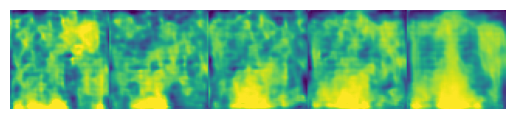

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 1: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.20it/s, train_loss=0.448]

Validation


Validation loss: 0.256


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.45it/s]


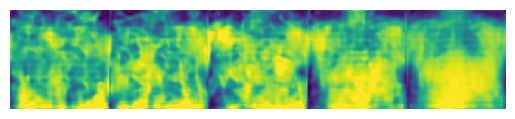

Epoch 2: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.26it/s, train_loss=0.107]

Validation


Validation loss: 0.253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.54it/s]


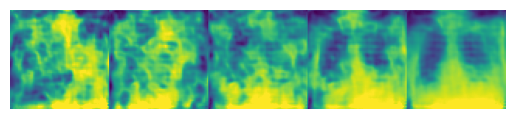

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 3: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.24it/s, train_loss=0.309]

Validation


Validation loss: 0.250


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.86it/s]


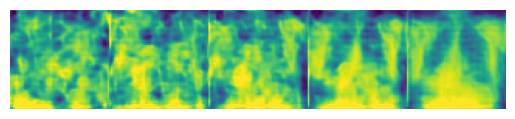

Epoch 4: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.39it/s, train_loss=0.228]

Validation


Validation loss: 0.238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.33it/s]


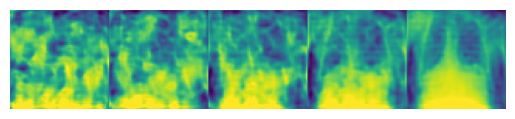

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 5: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.34it/s, train_loss=0.227]

Validation


Validation loss: 0.253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.91it/s]


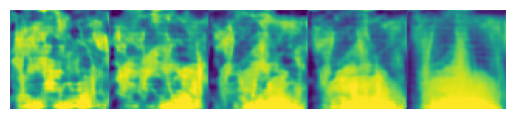

Epoch 6: 100%|██████████████████████████████████| 998/998 [00:55<00:00, 18.07it/s, train_loss=0.405]

Validation


Validation loss: 0.254


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.24it/s]


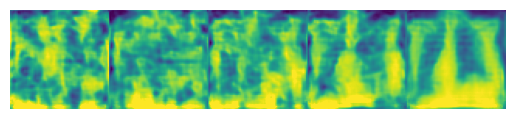

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 7: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.21it/s, train_loss=0.278]

Validation


Validation loss: 0.249


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.64it/s]


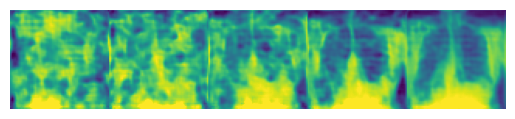

Epoch 8: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.27it/s, train_loss=0.356]

Validation


Validation loss: 0.233


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.12it/s]


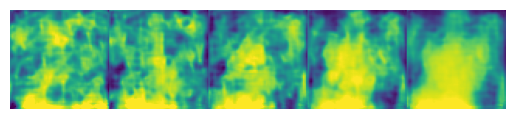

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 9: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.24it/s, train_loss=0.299]


Validation
Validation loss: 0.253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.68it/s]


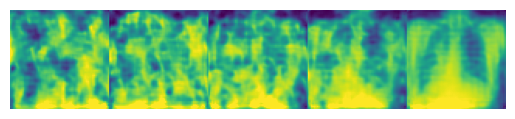

Epoch 10: 100%|█████████████████████████████████| 998/998 [00:54<00:00, 18.18it/s, train_loss=0.201]

Validation


Validation loss: 0.249


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.90it/s]


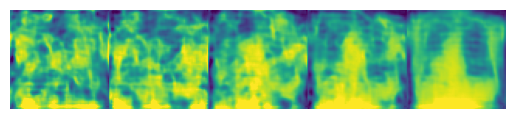

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 11: 100%|█████████████████████████████████| 998/998 [00:54<00:00, 18.16it/s, train_loss=0.273]

Validation


Validation loss: 0.246


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.42it/s]


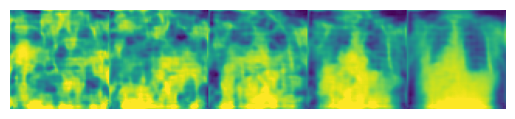

Epoch 12: 100%|█████████████████████████████████| 998/998 [00:54<00:00, 18.29it/s, train_loss=0.467]

Validation


Validation loss: 0.244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 131.93it/s]


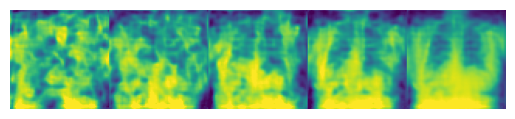

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 13: 100%|██████████████████████████████████| 998/998 [00:54<00:00, 18.24it/s, train_loss=0.32]

Validation


Validation loss: 0.246


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.04it/s]


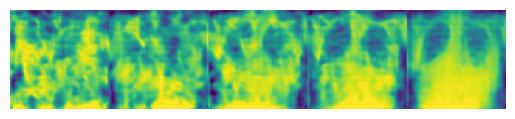

Epoch 14: 100%|█████████████████████████████████| 998/998 [00:54<00:00, 18.29it/s, train_loss=0.244]

Validation


Validation loss: 0.240


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.31it/s]


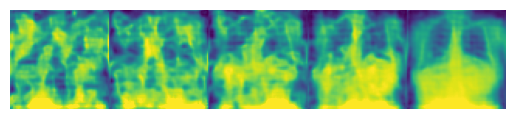

In [180]:
val_losses = []
train_losses = []
for e in range(n_epochs):
  progress_bar = tqdm(enumerate(training_loader), total = len(training_loader), ncols = 100)
  val_bar = tqdm(enumerate(validation_loader), total = len(validation_loader), ncols = 100)
  progress_bar.set_description("Epoch %d" %e)
  epoch_loss = 0.0
  latent_diffusion_model.train() 
  for ind, batch in progress_bar:
    image = batch['image'].to(device)
    with autocast(enabled = True):
        target = torch.randn(latent_shape).to(device)
        t = torch.randint(0, latent_scheduler.num_train_timesteps, (image.shape[0],), device=device).long()
        optimizer.zero_grad()
        noise_pred = latent_inferer(inputs = image, diffusion_model = latent_diffusion_model, noise = target, timesteps = t, 
                                   autoencoder_model = vae)
        loss = loss_fn(noise_pred, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    epoch_loss += loss.item()
    progress_bar.set_postfix({'train_loss': loss.item()})
  train_losses.append(epoch_loss / len(training_loader))
  if e%validate_every == 0:
      print("Validation")
      latent_diffusion_model.eval()
      val_loss = 0.0
      for batch in validation_loader:
        image = batch['image'].to(device)
        target = torch.randn(latent_shape).to(device)
        t = torch.randint(0, latent_scheduler.num_train_timesteps, (image.shape[0],), device=device).long()
        noise_pred = latent_inferer(inputs = image, diffusion_model = latent_diffusion_model, noise = target, timesteps = t, 
                                   autoencoder_model = vae)
        loss = loss_fn(noise_pred, target)
        val_loss += loss.item()
      val_losses.append(val_loss / len(validation_loader))
      print("Validation loss: %.3f" %val_losses[-1])

  if e%sample_every == 0:
    noise = torch.randn(latent_shape).to(device)
    samples, ints = latent_inferer.sample(input_noise=noise,
                                    diffusion_model=latent_diffusion_model,
                                    scheduler=latent_scheduler,
                                    save_intermediates=True,
                                    intermediate_steps=200,
                                    autoencoder_model = vae)
    # We plot these
    to_plot = process_dm_output(samples, ints, random_batch = True)
    plt.imshow(to_plot, vmin=0, vmax=1,); plt.axis('off')
    plt.show()




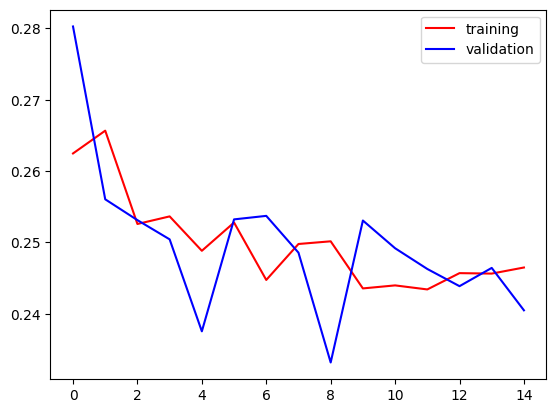

In [181]:
epochs = list(range(n_epochs))
plt.plot(epochs, train_losses, 'r'); plt.plot(epochs, val_losses, 'b'); 
plt.legend(['training', 'validation']); 
plt.show()

We can see that the LDM is far from converging! Training for more would get us consistent better outputs, but we can already see some progress. 

**Note**: it's not obvious when a diffusion model has converged, because the loss is dependent on the time-step; because each iteration randomly samples a time step, the loss might sometimes not reflect whether the model is actually stagnating or is still training.

Bit of cleaning, just in case...

In [ ]:
latent_diffusion_model = latent_diffusion_model.detach().cpu()
vae = vae.detach().cpu()

### 3. Training a LDM with conditioning

So far, we have been training an unconditioned generative model. Now we will try to do some conditioning on it. To make it very easy, we will create an "anomaly" in some of the images by randomly setting random 20x20 squares to 0.0. To force this we will implement it in a brute-force way during training.  

We create a function to do this for a specific batch:

In [363]:
from copy import deepcopy
def insert_anomaly(batch, anomaly_values = None, anomaly_shape = [20,20]):
    spatial_image_shape = list(batch['image'].shape[2:])
    out_image = batch['image']
    if anomaly_values is not None and len(anomaly_values) != out_image.shape[0]:
        raise ValueError("anomaly_values should have the same length as batch size!")
    for b in range(out_image.shape[0]):
        if anomaly_values is None:
            anomaly_values = np.random.choice(range(2), out_image.shape[0])
        else:
            anomaly_values = np.asarray(anomaly_values)
        if anomaly_values[b]==1.0:
            left_top_corner = [np.random.randint(spatial_image_shape[0]-anomaly_shape[0]-1), 
                               np.random.randint(spatial_image_shape[1]-anomaly_shape[1]-1)]
            out_image[b, 0, left_top_corner[0]:(left_top_corner[0]+anomaly_shape[0]),  
                           left_top_corner[1]:(left_top_corner[1]+anomaly_shape[1])] = 0.0
    return out_image, anomaly_values    
            

Let's try it:

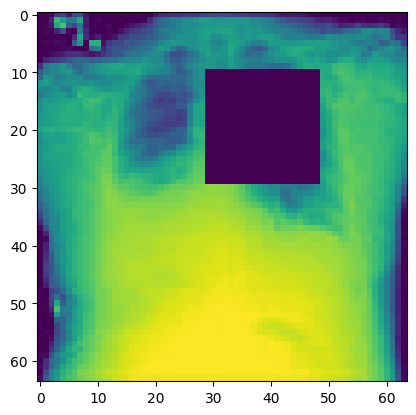

In [364]:
batch = next(iter(training_loader))
batch['image'] = batch['image'][0:1,...]
out_image, anomaly_values = insert_anomaly(batch, anomaly_values = [1.0])
plt.imshow(out_image[0,0,...]); plt.show()

#### Re-train the VAE

Not much changes in the VAE. We just need to make it see our squares so that it learns to reconstruct them.

In [365]:
vae = AutoencoderKL(
    spatial_dims = 2,
    in_channels = 1,
    out_channels = 1,
    num_res_blocks = [2, 2, 2],
    num_channels = [16, 32,64],
    attention_levels = [False, False, False],
    latent_channels = 8,
    norm_num_groups = 16
)

In [366]:
n_epochs = 20
lr = 0.0001
w_recon = 1.0
w_perc = 0.5
w_kl = 0.00001
scaler_vae = GradScaler()
recons_loss = torch.nn.functional.l1_loss
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=lr)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device %s" %device)
vae =vae.to(device);
from generative.losses import PerceptualLoss
perceptual_loss = PerceptualLoss(spatial_dims = 2, network_type = "radimagenet_resnet50").to(device)

Device cuda


  0%|                                                                                           | 0/998 [00:00<?, ?it/s]

Epoch 0: 100%|██████| 998/998 [01:14<00:00, 13.38it/s, train_loss=0.64, kl_loss=932, recons_loss=0.285, perc_loss=0.691]

Validation


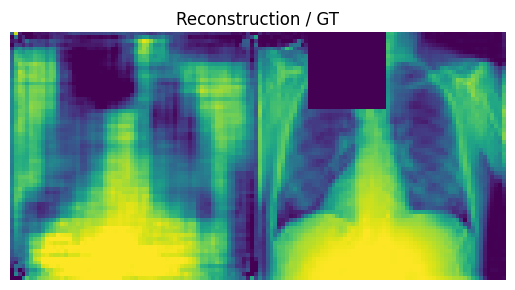

Validation loss: 0.114


  0%|                                                                                           | 0/998 [00:00<?, ?it/s]

  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 2: 100%|█| 998/998 [01:14<00:00, 13.34it/s, train_loss=0.211, kl_loss=1.74e+3, recons_loss=0.0799, perc_loss=0.228
  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 3: 100%|█| 998/998 [01:13<00:00, 13.52it/s, train_loss=0.178, kl_loss=1.75e+3, recons_loss=0.0667, perc_loss=0.187
  0%|                                                                                           | 0/998 [00:00<?, ?it/s]

  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 5: 100%|█| 998/998 [01:14<00:00, 13.41it/s, train_loss=0.134, kl_loss=1.66e+3, recons_loss=0.0535, perc_loss=0.128
  0%|                         

Validation


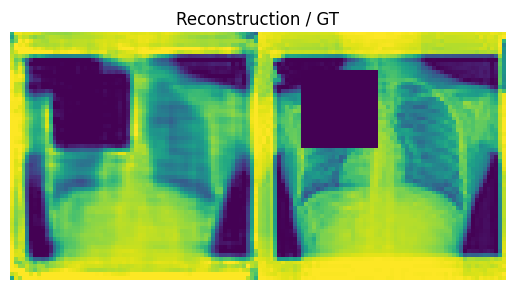

Validation loss: 0.041


  0%|                                                                                           | 0/131 [01:16<?, ?it/s]
Epoch 11: 100%|█| 998/998 [01:13<00:00, 13.59it/s, train_loss=0.0883, kl_loss=1.43e+3, recons_loss=0.0396, perc_loss=0.0
  0%|                                                                                           | 0/998 [00:00<?, ?it/s]

  0%|                                                                                           | 0/131 [01:13<?, ?it/s]
Epoch 12: 100%|█| 998/998 [01:14<00:00, 13.35it/s, train_loss=0.0863, kl_loss=1.4e+3, recons_loss=0.0387, perc_loss=0.06
  0%|                                                                                           | 0/131 [01:14<?, ?it/s]
Epoch 13: 100%|█| 998/998 [01:14<00:00, 13.45it/s, train_loss=0.0807, kl_loss=1.38e+3, recons_loss=0.0373, perc_loss=0.0
  0%|                                                                                           | 0/998 [00:00<?, ?it/s]

  0%|                         

In [367]:
val_epoch_loss = 0.0
perceptual_losses = []
recons_losses = []
epoch_losses = []
val_epoch_losses = []
kl_losses = []
for e in range(n_epochs):
  progress_bar = tqdm(enumerate(training_loader), total = len(training_loader), ncols = 120)
  val_bar = tqdm(enumerate(validation_loader), total = len(validation_loader), ncols = 120)
  progress_bar.set_description("Epoch %d" %e)
  epoch_loss = 0.0
  kl_epoch_loss = 0.0
  p_epoch_loss = 0.0
  recons_epoch_loss = 0.0
  vae.train() 
  for ind, batch in progress_bar:
    # We insert the anomaly by calling our function on the batch (leaving anomaly values at random)
    anomaly_image, _ = insert_anomaly(batch)
    anomaly_image = anomaly_image.to(device)

    with autocast(enabled = True):
        reconstruction, z_mu, z_sigma = vae(anomaly_image)
        optimizer_vae.zero_grad()
        recons_it_loss = recons_loss(reconstruction, anomaly_image)
        perc_it_loss = perceptual_loss(reconstruction.float(), anomaly_image.float())
        kl_it_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2])
        kl_it_loss = torch.sum(kl_it_loss) / kl_it_loss.shape[0]
        loss = w_recon * recons_it_loss + w_perc * perc_it_loss + w_kl * kl_it_loss
    scaler_vae.scale(loss).backward()
    scaler_vae.step(optimizer_vae)
    scaler_vae.update()
    epoch_loss += loss.item()
    kl_epoch_loss += kl_it_loss.item()
    p_epoch_loss += perc_it_loss.item()
    recons_epoch_loss +=recons_it_loss.item()
    del reconstruction, z_mu, z_sigma, loss, perc_it_loss, recons_it_loss, kl_it_loss
    progress_bar.set_postfix({'train_loss': epoch_loss / (ind+1), 
                              'kl_loss': kl_epoch_loss /(ind+1),
                              'recons_loss': recons_epoch_loss / (ind+1),
                              'perc_loss': p_epoch_loss / (ind+1)})
  recons_losses.append(recons_epoch_loss / len(training_loader)) 
  kl_losses.append(kl_epoch_loss / len(training_loader)) 
  perceptual_losses.append(p_epoch_loss / len(training_loader))
  epoch_losses.append(epoch_loss / len(training_loader))
  train_losses.append(epoch_loss / len(training_loader))
    
  if e%validate_every == 0:
      print("Validation")
      vae.eval()
      vae_epoch_loss = 0.0
      for ind, batch in enumerate(validation_loader):
        # We insert the anomaly by calling our function on the batch (leaving anomaly values at random)
        anomaly_image, _ = insert_anomaly(batch)
        anomaly_image = anomaly_image.to(device)
        reconstruction, _, _ = vae(anomaly_image)
        recons_it_loss = recons_loss(reconstruction, anomaly_image)
        val_epoch_loss += recons_it_loss.item()
        if ind==0:
            to_plot = log_ae_result(reconstruction, anomaly_image, random_batch = True)
            plt.imshow(to_plot, vmin = 0.0, vmax = 1.0); plt.axis('off'); plt.title("Reconstruction / GT");plt.show();
        del recons_it_loss, reconstruction, anomaly_image 
      val_epoch_loss = val_epoch_loss / len(validation_loader)
      print("Validation loss: %.3f" %val_epoch_loss)
  val_epoch_losses.append(val_epoch_loss)

Again, let's look for the scale factor

In [368]:
# Which scale factor will be good? We calculate the average of 1/torch.std(z) for our test set.
vae.to(device)
potential_scale_factor = 0.0
for batch in test_loader:
  im = batch['image'].to(device)
  z = vae.encode_stage_2_inputs(im)
  potential_scale_factor += (1/torch.std(z)).item()
potential_scale_factor /= len(test_loader)
print(potential_scale_factor)

0.9862014355738301


#### Retrain the diffusion model

Redefine the diffusion model parameters to allow for conditioning:

In [373]:
# Configuration
# Diffusion model configuration
spatial_dims = 2 # We are using 2D
in_channels = 8 # Now we have the number of latent channels!
num_channels = (64, 128, 256) # Number of channels at every level of the U-Net
attention_levels = (False, True, True) # At which level of the U-Net you want attention levels: attention blocks have a lot of parameters,
#and they can slow optimisation time, and also take a lot of GPU space, so you can't always have a lot of them.
num_res_blocks = 1 # Number of residual blocks per U-Net level
num_head_channels = 8 # This is the number of different attention heads in the attention blocks (the more, the more things in parallel your attention blocks will be looking at in the input)
with_conditioning = True
cross_attention_dim = 1

# Scheduler configuration
# With number_time_steps, beta_start and beta_end, our scheduler will automatically calculate the variance of the noise that gets added (and accumulates) across the forward process.
number_time_steps = 1000
schedule = "scaled_linear_beta" # The schedule is the way noise evolves during the forward process: it can be a cosine function, linear etc. linear is the most common.
prediction_type = "epsilon" # We are saying that our network is predicting the added noise between steps. This is not always true: other approaches can be used (such as predicting the denoised image
#directly, or a mix between the two). To keep things simple, we stick with predicting the noise, which is what 'epsilon' is doing.
beta_start = 0.0015 # Variance at the beginning of the process
beta_end = 0.0195 # Varance at the end of the process

In [374]:
latent_diffusion_model = DiffusionModelUNet(
    spatial_dims = spatial_dims,
    in_channels = in_channels,
    out_channels = in_channels,
    num_channels = num_channels,
    attention_levels = attention_levels,
    num_res_blocks = num_res_blocks,
    num_head_channels = num_head_channels,
    with_conditioning = with_conditioning,
    cross_attention_dim = cross_attention_dim,
)

latent_scheduler = DDPMScheduler(
    num_train_timesteps = number_time_steps,
    schedule = schedule,
    prediction_type = prediction_type,
    beta_start = beta_start,
    beta_end = beta_end,
)

latent_inferer = LatentDiffusionInferer(scheduler = latent_scheduler, scale_factor = potential_scale_factor)
# We do not specify crop and pad here because our shapes are fine.

In [379]:
# TRAINING PARAMETERS
n_epochs = 15
lr = 0.0001
validate_every = 1
sample_every = 1
optimizer = torch.optim.Adam(latent_diffusion_model.parameters(), lr=lr)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.mse_loss
scaler = GradScaler()
latent_shape = [batch_size, 8, 64//(2**2), 64//(2**2)] # Latent space shape
print("Device set to: %s" %device)
latent_diffusion_model.to(device);

Device set to: cuda


  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 0: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.43it/s, train_loss=0.171]

Validation


Validation loss: 0.273


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.79it/s]


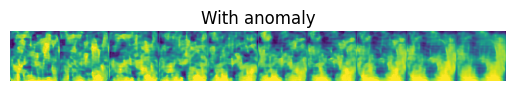

Epoch 1: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.45it/s, train_loss=0.167]

Validation


Validation loss: 0.268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 83.10it/s]


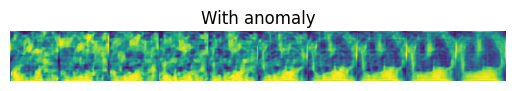

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 2: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.43it/s, train_loss=0.129]

Validation


Validation loss: 0.256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.77it/s]


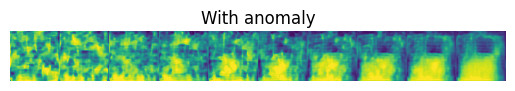

Epoch 3: 100%|███████████████████████████████████| 998/998 [01:20<00:00, 12.44it/s, train_loss=0.27]

Validation


Validation loss: 0.245


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.77it/s]


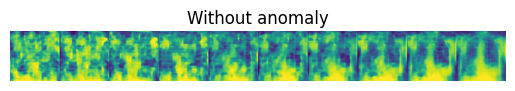

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 4: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.34it/s, train_loss=0.234]

Validation


Validation loss: 0.252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.98it/s]


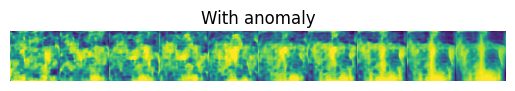

Epoch 5: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.33it/s, train_loss=0.277]

Validation


Validation loss: 0.268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.91it/s]


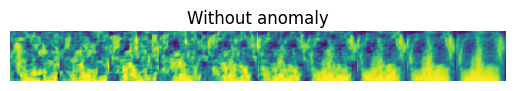

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 6: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.42it/s, train_loss=0.326]

Validation


Validation loss: 0.246


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.02it/s]


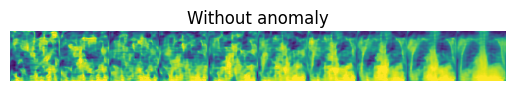

Epoch 7: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.42it/s, train_loss=0.249]

Validation


Validation loss: 0.228


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.72it/s]


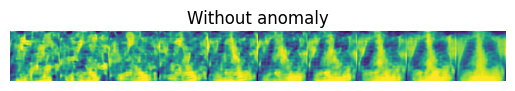

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 8: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.37it/s, train_loss=0.399]

Validation


Validation loss: 0.261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.97it/s]


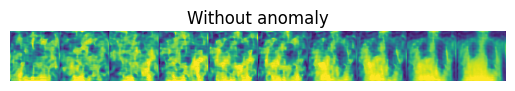

Epoch 9: 100%|██████████████████████████████████| 998/998 [01:20<00:00, 12.39it/s, train_loss=0.135]

Validation


Validation loss: 0.233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.48it/s]


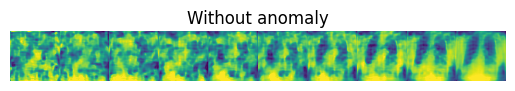

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 10: 100%|████████████████████████████████| 998/998 [01:20<00:00, 12.36it/s, train_loss=0.0701]

Validation


Validation loss: 0.256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.74it/s]


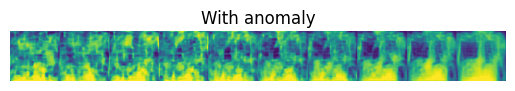

Epoch 11: 100%|█████████████████████████████████| 998/998 [01:20<00:00, 12.33it/s, train_loss=0.113]

Validation


Validation loss: 0.244


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.56it/s]


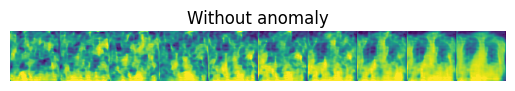

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 12: 100%|█████████████████████████████████| 998/998 [01:20<00:00, 12.39it/s, train_loss=0.277]

Validation


Validation loss: 0.237


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.14it/s]


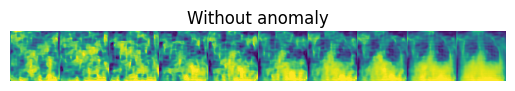

Epoch 13: 100%|█████████████████████████████████| 998/998 [01:20<00:00, 12.34it/s, train_loss=0.227]

Validation


Validation loss: 0.259


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.08it/s]


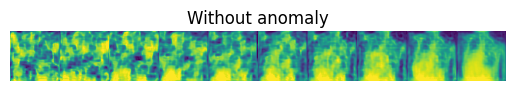

  0%|                                                                       | 0/998 [00:00<?, ?it/s]

Epoch 14: 100%|█████████████████████████████████| 998/998 [01:21<00:00, 12.30it/s, train_loss=0.318]

Validation


Validation loss: 0.247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.77it/s]


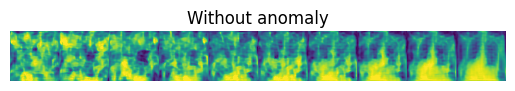

In [380]:
val_losses = []
train_losses = []

for e in range(n_epochs):
  progress_bar = tqdm(enumerate(training_loader), total = len(training_loader), ncols = 100)
  val_bar = tqdm(enumerate(validation_loader), total = len(validation_loader), ncols = 100)
  progress_bar.set_description("Epoch %d" %e)
  epoch_loss = 0.0
  latent_diffusion_model.train() 
  
  for ind, batch in progress_bar:
    # We insert the anomaly by calling our function on the batch (leaving anomaly values at random)
    anomaly_image, conditioning = insert_anomaly(batch)
    anomaly_image = anomaly_image.to(device)

    # We need to reshape our conditioning to a Bx1xCONDITIONING_DIM (1, in our case)
    conditioning = torch.tensor(conditioning).unsqueeze(-1).unsqueeze(-1)
    conditioning = conditioning.float().to(device)
    
    with autocast(enabled = True):
        target = torch.randn(latent_shape).to(device)
        t = torch.randint(0, latent_scheduler.num_train_timesteps, (image.shape[0],), device=device).long()
        optimizer.zero_grad()
        noise_pred = latent_inferer(inputs = anomaly_image, diffusion_model = latent_diffusion_model, noise = target, timesteps = t, 
                                   autoencoder_model = vae, condition = conditioning)
        loss = loss_fn(noise_pred, target)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    epoch_loss += loss.item()
    progress_bar.set_postfix({'train_loss': loss.item()})
  train_losses.append(epoch_loss / len(training_loader))
  
  if e%validate_every == 0:
      print("Validation")
      latent_diffusion_model.eval()
      val_loss = 0.0
      for batch in validation_loader:
          # We insert the anomaly by calling our function on the batch (leaving anomaly values at random)
          anomaly_image, conditioning = insert_anomaly(batch)
          anomaly_image = anomaly_image.to(device)
          # We need to reshape our conditioning to a Bx1xCONDITIONING_DIM (1, in our case)
          conditioning = torch.tensor(np.asarray(conditioning)).unsqueeze(-1).unsqueeze(-1)
          conditioning = conditioning.float().to(device)
          image = batch['image'].to(device)
          target = torch.randn(latent_shape).to(device)
          t = torch.randint(0, latent_scheduler.num_train_timesteps, (image.shape[0],), device=device).long()
          noise_pred = latent_inferer(inputs = anomaly_image, diffusion_model = latent_diffusion_model, noise = target, timesteps = t, 
                                   autoencoder_model = vae, condition = conditioning)
          loss = loss_fn(noise_pred, target)
          val_loss += loss.item()
      val_losses.append(val_loss / len(validation_loader))
      print("Validation loss: %.3f" %val_losses[-1])

  if e%sample_every == 0:
    noise = torch.randn(latent_shape).to(device)
    # We need to reshape our conditioning to a Bx1xCONDITIONING_DIM (1, in our case)
    conditioning = torch.tensor(np.random.choice(range(2), noise.shape[0])).unsqueeze(-1).unsqueeze(-1)
    conditioning = conditioning.float().to(device)
    samples, ints = latent_inferer.sample(input_noise=noise,
                                    diffusion_model=latent_diffusion_model,
                                    scheduler=latent_scheduler,
                                    save_intermediates=True,
                                    autoencoder_model = vae,
                                    conditioning = conditioning)
    # We plot these
    to_plot, b = process_dm_output(samples, ints, random_batch = True, with_anomaly = True)
    if conditioning[b, 0, 0]:
        title = "With anomaly"
    else:
        title =  "Without anomaly"
    plt.imshow(to_plot, vmin=0, vmax=1,); plt.axis('off'); plt.title(title);
    plt.show()



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.05it/s]


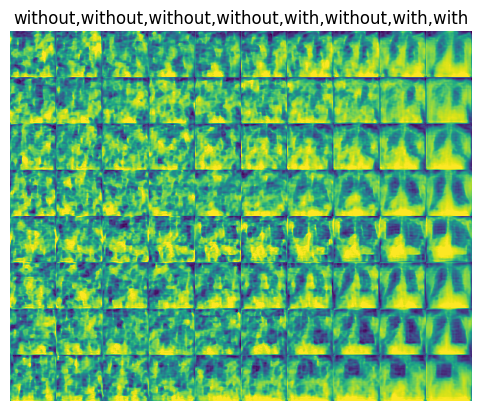

In [382]:
n_samples = 1
latent_diffusion_model.eval()
for s in range(n_samples):
    noise = torch.randn(latent_shape).to(device)
    # We need to reshape our conditioning to a Bx1xCONDITIONING_DIM (1, in our case)
    anomaly_values = np.random.choice(range(2), noise.shape[0])
    conditioning = torch.tensor(anomaly_values).unsqueeze(-1).unsqueeze(-1)
    conditioning = conditioning.float().to(device)
    samples, ints = latent_inferer.sample(input_noise=noise,
                                    diffusion_model=latent_diffusion_model,
                                    scheduler=latent_scheduler,
                                    save_intermediates=True,
                                    autoencoder_model = vae,
                                    conditioning = conditioning)
    # We plot these
    to_plot, _ = process_dm_output(samples, ints, with_anomaly = True)
    title = ["with" if i else "without" for i in anomaly_values]
    plt.imshow(to_plot, vmin=0, vmax=1,); plt.axis('off'); plt.title(",".join(title));
    plt.show()


### 4. (Bonus) VQ-VAE

In the example above, we obtain the latent space using a spatial VAE. Vector-Quantised Autoencoders (VQ-VAEs) can also be used for this task.

You can check the tutorial about how to train a VQ-VAE in here: https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_vqvae/2d_vqvae_tutorial.ipynb.

Other than some changes in the training process, the mechanics of working with the autoencoder and the diffusion model are the same.
